# Optimization: Version 1.0

## Setup

In [1]:
# libraries to deal with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# libraries to save/load models
import os
import joblib

## Loading Models

In [2]:
# load encoder
label_encoder = joblib.load('../preprocessors/label_encoder.pkl')

# load models
performance_model = joblib.load('../models/performance_prediction_model.pkl')
salary_model = joblib.load('../models/salary_prediction_model.pkl')

# load feature info to know feature order/names
feature_info = joblib.load('../data/processed/performance_feature_info.pkl')

In [3]:
feature_info

{'categorical_cols': ['Job_Title', 'Education_Level'],
 'numeric_cols': ['Performance_Score',
  'Monthly_Salary',
  'Work_Hours_Per_Week',
  'Projects_Handled',
  'Overtime_Hours',
  'Sick_Days',
  'Remote_Work_Frequency',
  'Team_Size',
  'Training_Hours'],
 'onehot_cols': ['Job_Title'],
 'ordinal_cols': ['Education_Level'],
 'all_features': ['Overtime_Hours',
  'Job_Title',
  'Education_Level',
  'Sick_Days',
  'Projects_Handled',
  'Training_Hours',
  'Monthly_Salary',
  'Work_Hours_Per_Week',
  'Remote_Work_Frequency',
  'Team_Size']}

## Constants from Used Dataset

In [4]:
MINIMUM_MONTHLY_WAGE = 3850
MAXIMUM_MONTHLY_WAGE = 9000

## Helper Functions: Preparing Data

In [5]:
def prepare_features_for_performance_prediction(employee_profile, offered_salary):
    """
    Prepare features DataFrame for performance prediction model
    
    Args:
        employee_profile: dict with employee features (without Monthly_Salary and Performance_Score)
        offered_salary: monthly salary amount
    
    Returns:
        df: DataFrame with features in correct order for performance prediction model
    """
    # create DataFrame from employee profile
    df = pd.DataFrame([employee_profile])
    
    # add salary to the DataFrame
    df['Monthly_Salary'] = offered_salary
    
    # get correct column order
    feature_order = feature_info['all_features']
    
    # reorder columns to match training data
    df = df[feature_order]
    
    return df

In [6]:
def prepare_features_for_salary_prediction(employee_profile, target_performance):
    """
    Prepare features DataFrame for salary prediction model
    
    Args:
        employee_profile: dict with employee features (without Monthly_Salary and Performance_Score)
        target_performance: target performance level (1-5)
    
    Returns:
        df: DataFrame with features in correct order for salary prediction model
    """
    # create DataFrame from employee profile
    df = pd.DataFrame([employee_profile])
    
    # add target performance to the DataFrame
    df['Performance_Score'] = target_performance
    
    # get correct column order # replace Monthly_Salary with Performance_Score
    feature_order = [
        'Performance_Score' if c == 'Monthly_Salary' else c
        for c in feature_info['all_features']
    ]
    
    # reorder columns to match training data
    df = df[feature_order]
    
    return df

## Optimization Methods

This notebook uses two approaches to find optimal salary recommendations:

### 1. Direct Prediction Method

Trained models are used to directly predict outputs without optimization. This method is fast and deterministic. 

It is used in cases where a single input maps directly to a single output through direct model prediction.

> - **Case 1** takes a target performance level (e.g., 4) and directly predicts the corresponding salary (e.g., `$7000`).
> - **Case 2** takes an offered salary (e.g., `$6000`) and directly predicts the expected performance level (e.g., 2).

### 2. Grid Search Method

The optimal solution is found by systematically evaluating evenly spaced points across a range, selecting the best among those evaluated points.

It is used in cases where finding the global optimum is required, and when multiple solutions exist, selecting the lowest cost option. The performance model outputs *discrete* integers (1-5), creating plateaus where traditional optimization algorithms can get stuck or miss the global optimum. Grid search ensures finding the true optimum efficiently.

> - **Case 3A** finds the salary within a budget (e.g., `$7500`) that maximizes performance.
> - **Case 3B** finds the salary within a budget (e.g., `$7500`) that maximizes ROI (performance per dollar).
> - **Case 4** finds the minimum salary where predicted performance meets or exceeds a target (e.g., performance 4.5 requires at least performance 5).

## Case 1: (For Employee) Salary Recommendation Based on Target Performance

The employee perspective focuses on **identifying the appropriate salary amount to request** during negotiations based on a specific performance level. Employees need information about what salary corresponds to their intended performance contribution.

This answers: "If I deliver this performance, what salary should I ask for?"

In [7]:
def employee_maximize_salary(employee_profile, target_performance, salary_range=(MINIMUM_MONTHLY_WAGE, MAXIMUM_MONTHLY_WAGE)):
    """
    Find optimal salary for employee based on their target performance level
    
    Args:
        employee_profile: dict with employee features (without Monthly_Salary and Performance_Score)
        target_performance: desired performance level (1-5) that employee will deliver
        salary_range: tuple of (min_monthly_salary, max_monthly_salary) for validation
    
    Returns:
        recommended_salary: salary that should be requested based on target performance
    """
    
    # prepare features with DataFrame
    df = prepare_features_for_salary_prediction(employee_profile, target_performance)
    
    # predict monthly salary
    predicted_salary = salary_model.predict(df)[0]

    # clamp/constrain predicted salary to reasonable salary range
    recommended_salary = np.clip(predicted_salary, salary_range[0], salary_range[1])
    
    return recommended_salary

## Case 2: (For Employee) Performance Recommendation Based on Offered Salary

The employee perspective focuses on **identifying the appropriate performance level to deliver** given a specific salary offer. Employees need this information to match their effort and contributions to the compensation level.

This answers: "If they offer this salary, what performance should I deliver?"    

In [8]:
def employee_match_performance(employee_profile, offered_salary):
    """
    Find optimal performance for employee based on offered salary
    
    Args:
        employee_profile: dict with employee features (without Monthly_Salary and Performance_Score)
        offered_salary: monthly salary amount offered by employer
    
    Returns:
        recommended_performance: performance level that should be delivered for this salary
    """
    
    # prepare features with DataFrame
    df = prepare_features_for_performance_prediction(employee_profile, offered_salary)
    
    # predict performance score
    pred_encoded = performance_model.predict(df)[0]
    
    # decode the encoded performance label back to original Performance_Score scale
    recommended_performance = label_encoder.inverse_transform([pred_encoded])[0]
    
    return recommended_performance

## Case 3A: (For Employer) Performance Maximization Within Salary Budget

The employer perspective focuses on **identifying the salary amount within a budget range that maximizes expected employee performance**. Employers need this information to allocate salary budgets effectively.

This case uses grid search to find the salary within budget that maximizes expected employee performance.

This answers: "If I have this salary budget, what salary should I offer to maximize performance?"

In [9]:
def employer_maximize_performance(employee_profile, salary_budget, salary_range=(MINIMUM_MONTHLY_WAGE, MAXIMUM_MONTHLY_WAGE)):
    """
    Find optimal salary for employer to maximize performance within budget
    
    Args:
        employee_profile: dict with employee features (without Monthly_Salary and Performance_Score)
        salary_budget: maximum monthly salary budget available
        salary_range: tuple of (min_monthly_salary, max_monthly_salary)
    
    Returns:
        recommended_salary: salary within budget that maximizes performance
        expected_performance: maximum expected performance at recommended salary
        curve: array of (salary, performance) pairs for visualization
    """

    # set the bounds for optimization search
    bounds = (salary_range[0], min(salary_budget, salary_range[1]))
    
    # use grid search
    salaries_to_test = np.linspace(bounds[0], bounds[1], 200)  # more points = better coverage
    
    # evaluate performance at each salary
    performances = [employee_match_performance(employee_profile, s) for s in salaries_to_test]
    
    # find the maximum performance and corresponding salary
    max_performance = max(performances)
    max_performance_indices = [i for i, p in enumerate(performances) if p == max_performance]
    
    # pick the lowest salary among all salaries that give the same performance
    best_idx = max_performance_indices[0]  # first index = lowest salary
    recommended_salary = salaries_to_test[best_idx]
    expected_performance = performances[best_idx]
    
    # check performance exactly at budget limit (in case grid search missed it)
    budget_performance = employee_match_performance(employee_profile, salary_budget)
    if budget_performance > max_performance:
        recommended_salary = salary_budget
        expected_performance = budget_performance
    elif budget_performance == max_performance:
        # use the lower of the two if budget also gives max performance
        recommended_salary = min(recommended_salary, salary_budget)

    # visualization
    ## create 100 evenly spaced salary values across the search bounds
    salaries = np.linspace(bounds[0], bounds[1], 100)
    
    ## for each salary value, predict the corresponding performance
    ### list comprehension creates array of performance predictions across the salary range
    performances_curve = [employee_match_performance(employee_profile, s) for s in salaries]
    
    ## create 2-column array
    curve = np.column_stack([salaries, performances_curve])
    
    return recommended_salary, expected_performance, curve

## Case 3B: (For Employer) ROI Maximization

The employer perspective focuses on **identifying the salary amount that maximizes ROI** by optimizing the performance per dollar spent ratio. Employers need this information to allocate salary budgets most efficiently, ensuring that each dollar of compensation yields the maximum possible performance.

This case uses grid search to find the salary within budget that maximizes ROI.

This answers: "What salary maximizes performance per dollar spent (best ROI)?"

In [10]:
def employer_maximize_roi(employee_profile, salary_budget, salary_range=(MINIMUM_MONTHLY_WAGE, MAXIMUM_MONTHLY_WAGE)):
    """
    Find optimal salary for employer to maximize ROI (performance per dollar)
    
    Args:
        employee_profile: dict with employee features (without Monthly_Salary and Performance_Score)
        salary_budget: maximum monthly salary budget available
        salary_range: tuple of (min_monthly_salary, max_monthly_salary)
    
    Returns:
        recommended_salary: salary within budget that maximizes performance per dollar (ROI)
        expected_performance: expected performance at recommended salary
        roi: performance per dollar ratio at recommended salary
        curve: array of (salary, performance) pairs for visualization
    """
    
    # set the bounds for optimization search
    bounds = (salary_range[0], min(salary_budget, salary_range[1]))

    # use grid search
    salaries_to_test = np.linspace(bounds[0], bounds[1], 200)  # more points = better coverage
    
    # evaluate ROI at each salary
    rois = []
    performances = []
    for s in salaries_to_test:
        perf = employee_match_performance(employee_profile, s)
        roi = perf / s
        rois.append(roi)
        performances.append(perf)
    
    # find the maximum ROI and corresponding salary
    max_roi = max(rois)
    max_roi_indices = [i for i, r in enumerate(rois) if r == max_roi]
    
    # pick the lowest salary among all salaries that give the same ROI
    best_idx = max_roi_indices[0]  # first index = lowest salary
    recommended_salary = salaries_to_test[best_idx]
    expected_performance = performances[best_idx]
    expected_roi = rois[best_idx]
    
    # check ROI exactly at budget limit (in case grid search missed it)
    budget_performance = employee_match_performance(employee_profile, salary_budget)
    budget_roi = budget_performance / salary_budget
    if budget_roi > max_roi:
        recommended_salary = salary_budget
        expected_performance = budget_performance
        expected_roi = budget_roi
    elif budget_roi == max_roi:
        # use the lower of the two if budget also gives max ROI
        recommended_salary = min(recommended_salary, salary_budget)
    
    # visualization
    salaries = np.linspace(bounds[0], bounds[1], 100)
    performances_curve = [employee_match_performance(employee_profile, s) for s in salaries]
    curve = np.column_stack([salaries, performances_curve])
    
    return recommended_salary, expected_performance, expected_roi, curve

## Case 4: (For Employer) Salary Minimization for Target Performance

The employer perspective focuses on **identifying the minimum salary amount required to achieve a specific performance target**. Employers need this information to minimize compensation costs while meeting performance requirements.

This case uses grid search to find the minimum salary where predicted performance meets or exceeds the target performance level.

>**Note:** While fractional performance scores are accepted, the model only predicts integer ones. For a fractional target like 3.2, the function finds the minimum salary where predicted performance ≥ 3.2 (which will be performance 4, since 3 < 3.2 and only integer values are possible).

This answers: "If I need this performance level, what minimum salary should I offer?"

In [11]:
def employer_minimize_salary(employee_profile, target_performance, pay_raise, salary_budget=None, salary_range=(MINIMUM_MONTHLY_WAGE, MAXIMUM_MONTHLY_WAGE)):
    """
    Find minimum salary for employer to achieve target performance
    
    Args:
        employee_profile: dict with employee features (without Monthly_Salary and Performance_Score)
        target_performance: desired performance level (1-5) that employer needs
        pay_raise: salary increment amount for optimization
        salary_budget: optional maximum salary budget
        salary_range: tuple of (min_monthly_salary, max_monthly_salary) for validation
    
    Returns:
        recommended_salary: minimum salary that should be offered to achieve target performance
        expected_performance: expected performance at recommended salary
        cost_per_performance: cost per performance point
        curve: array of (salary, performance) pairs for visualization
    """

    # set bounds for visualization
    bounds = (salary_range[0], min(salary_budget or salary_range[1], salary_range[1]))
    
    # use grid search
    salaries_to_test = np.linspace(bounds[0], bounds[1], 200)
    
    # find minimum salary where performance >= target_performance
    recommended_salary = None
    for s in salaries_to_test:
        pred_performance = employee_match_performance(employee_profile, s)
        if pred_performance >= target_performance:
            recommended_salary = s
            expected_performance = pred_performance
            break

    # use all budget if no salary is possible within budget
    if recommended_salary is None:
        budget_performance = employee_match_performance(employee_profile, bounds[1])
        recommended_salary = bounds[1]
        expected_performance = budget_performance
        
        # warn if target not achievable
        if budget_performance < target_performance:
            print(f"Target performance {target_performance} not achievable within the current budget. Maximum performance at ${bounds[1]:.2f} is {budget_performance}.")

    cost_per_performance = recommended_salary / target_performance

    # visualization
    salaries = np.linspace(bounds[0], bounds[1], 100)
    performances_curve = [employee_match_performance(employee_profile, s) for s in salaries]
    curve = np.column_stack([salaries, performances_curve])

    return recommended_salary, expected_performance, cost_per_performance, curve

## Visualization: Performance vs Salary Curve

A curve displays how performance predictions change across different salary values.

*When to use visualization?*

| Case | Perspective | Objective | Visualize? | Rationale |
|:----:|-------------|-----------|:----------:|-----------|
| **1** | Employee | Maximize Salary | No | Single input giving single output. |
| **2** | Employee | Match Performance | No | Single input giving single output. |
| **3A** | Employer | Maximize performance | Yes | To show why the chosen salary is optimal. |
| **3B** | Employer | Maximize ROI | Yes | To show that optimal ROI often occurs at a lower salary than maximum performance. |
| **4** | Employer | Minimize Salary | Yes | To show where the minimum salary crosses the required performance. |

In [12]:
def plot_curve(curve, recommended_salary=None, expected_performance=None):
    """Plot performance vs salary curve"""
    plt.figure(figsize=(10, 6))
    plt.plot(curve[:, 0], curve[:, 1], 'b-', label='Expected Performance')
    
    if recommended_salary is not None:
        plt.axvline(recommended_salary, color='r', linestyle='--', 
                   label=f'Recommended Salary: ${recommended_salary:,.0f}')
        if expected_performance is not None:
            plt.plot(recommended_salary, expected_performance, 'ro', markersize=10,
                    label=f'Optimal Point: {expected_performance:.2f}')
    
    plt.xlabel('Monthly Salary ($)')
    plt.ylabel('Expected Performance Score')
    plt.title('Performance vs Salary Relationship')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

## Testing All Cases

In [13]:
example_profile = {
    'Job_Title': 'Developer',
    'Education_Level': "Bachelor",
    'Work_Hours_Per_Week': 40,
    'Projects_Handled': 5,
    'Overtime_Hours': 5,
    'Sick_Days': 2,
    'Remote_Work_Frequency': 50,
    'Team_Size': 8,
    'Training_Hours': 50
}

### Testing Case 1: Employee Maximize Salary

In [14]:
try:
    salary = employee_maximize_salary(example_profile, target_performance=4)
    print(f"✓ Case 1 passed: Recommended salary = ${salary:.2f}")
except Exception as e:
    print(f"✗ Case 1 failed: {e}")

✓ Case 1 passed: Recommended salary = $7000.00


### Testing Case 2: Employee Match Performance

In [15]:
try:
    performance = employee_match_performance(example_profile, offered_salary=6000)
    print(f"✓ Case 2 passed: Recommended performance = {performance}")
except Exception as e:
    print(f"✗ Case 2 failed: {e}")

✓ Case 2 passed: Recommended performance = 2


### Testing Case 3A: Employer Maximize Performance

Testing with budgets of `$8000`, `$7500`, and `$7300` to see if the results are still similar.

✓ Case 3A passed: Salary = $7249.25, Performance = 5


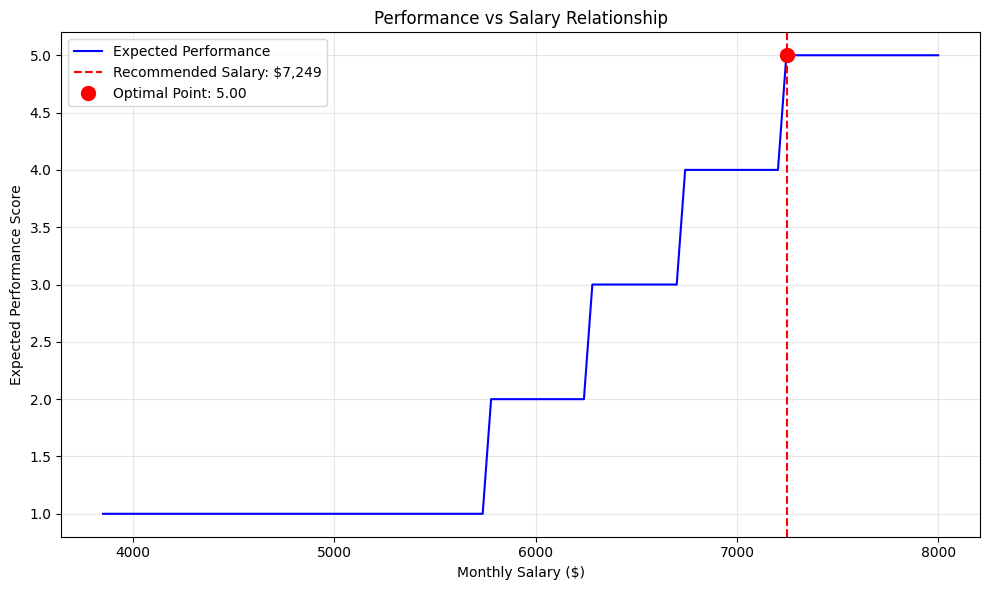

In [16]:
try:
    recommended_salary, expected_performance, curve = employer_maximize_performance(
        example_profile, salary_budget=8000
    )
    print(f"✓ Case 3A passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 3A failed: {e}")

✓ Case 3A passed: Salary = $7243.22, Performance = 5


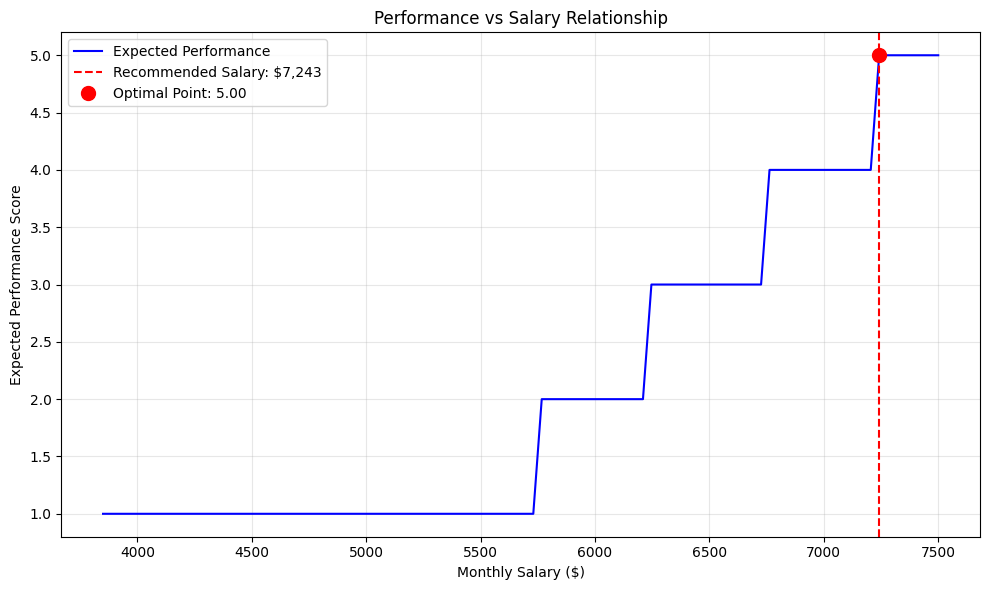

In [17]:
try:
    recommended_salary, expected_performance, curve = employer_maximize_performance(
        example_profile, salary_budget=7500
    )
    print(f"✓ Case 3A passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 3A failed: {e}")

✓ Case 3A passed: Salary = $7247.99, Performance = 5


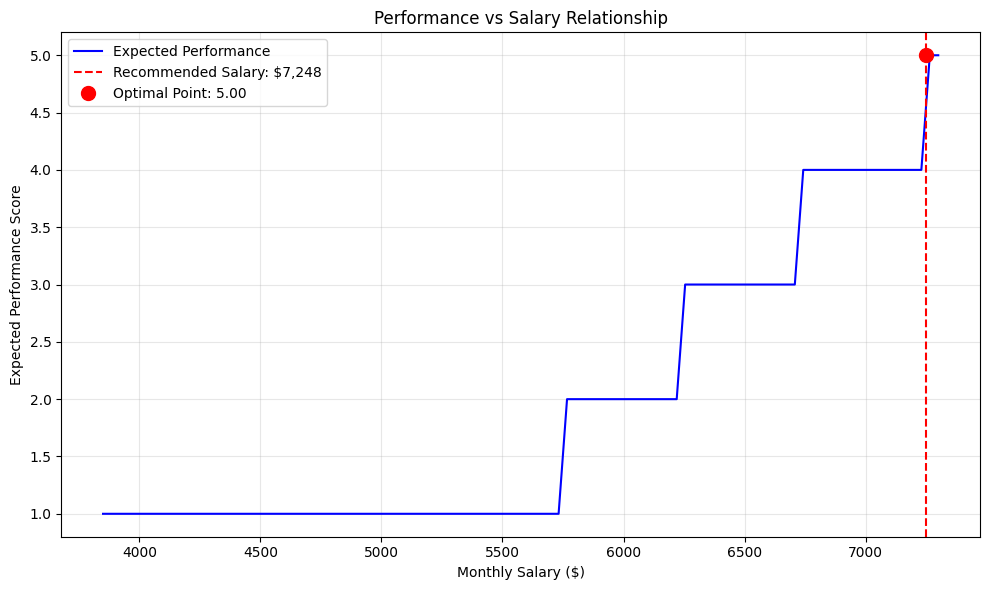

In [18]:
try:
    recommended_salary, expected_performance, curve = employer_maximize_performance(
        example_profile, salary_budget=7300
    )
    print(f"✓ Case 3A passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 3A failed: {e}")

### Testing Case 3B: Employer Maximize ROI

Testing with budgets of `$7500`, `$7300`, and `$7200` to see if the results are still similar and how they change.

✓ Case 3B passed: Salary = $7243.22, Performance = 5, ROI = 0.000690


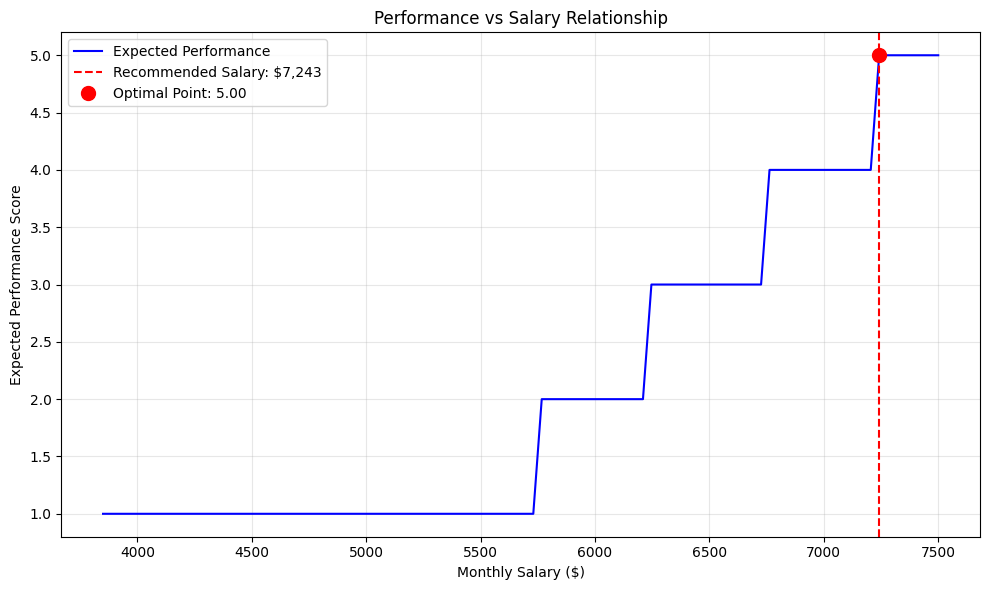

In [19]:
try:
    recommended_salary, expected_performance, roi, curve = employer_maximize_roi(
        example_profile, salary_budget=7500
    )
    print(f"✓ Case 3B passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}, ROI = {roi:.6f}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 3B failed: {e}")

✓ Case 3B passed: Salary = $7247.99, Performance = 5, ROI = 0.000690


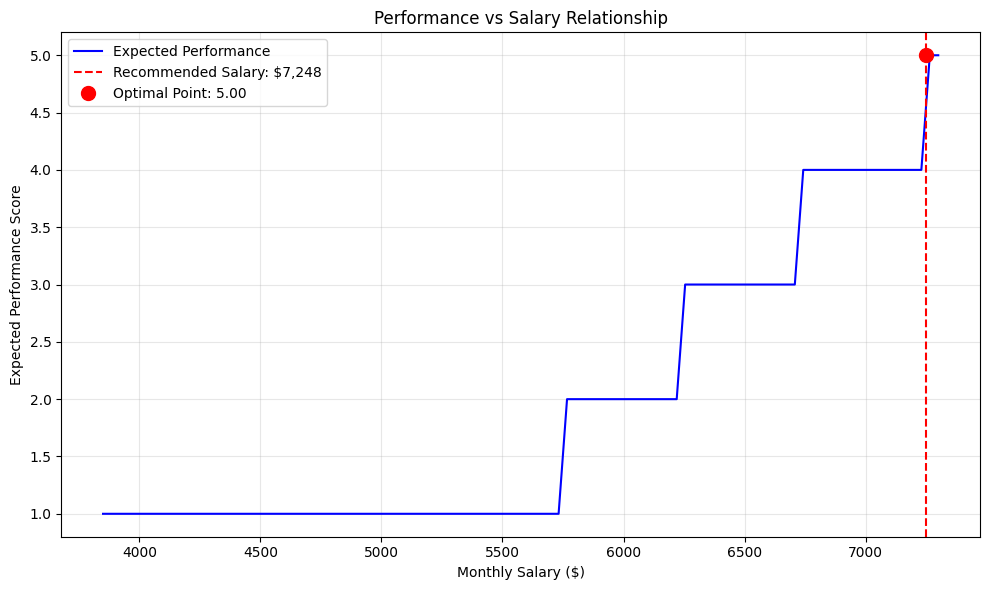

In [20]:
try:
    recommended_salary, expected_performance, roi, curve = employer_maximize_roi(
        example_profile, salary_budget=7300
    )
    print(f"✓ Case 3B passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}, ROI = {roi:.6f}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 3B failed: {e}")

✓ Case 3B passed: Salary = $6745.48, Performance = 4, ROI = 0.000593


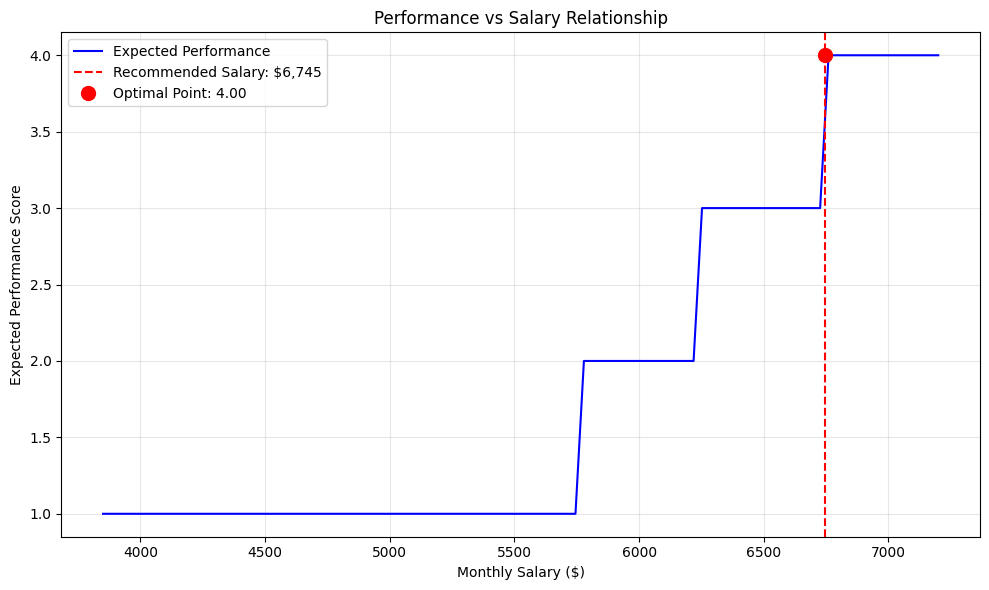

In [21]:
try:
    recommended_salary, expected_performance, roi, curve = employer_maximize_roi(
        example_profile, salary_budget=7200
    )
    print(f"✓ Case 3B passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}, ROI = {roi:.6f}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 3B failed: {e}")

### Testing Case 4: Employer Minimize Salary

Testing to achieve:
- Target performance `4` with no budget specified
- Target performance `4` with budget of `$6800`
- Target performance `4` with budget of `$6600`
- Target performance `2.8` with budget of `$6600`

This demonstrates how budget constraints affect the minimum salary required to achieve different performance targets.

✓ Case 4 passed: Salary = $6748.49, Performance = 4, Cost/Perf = $1687.12


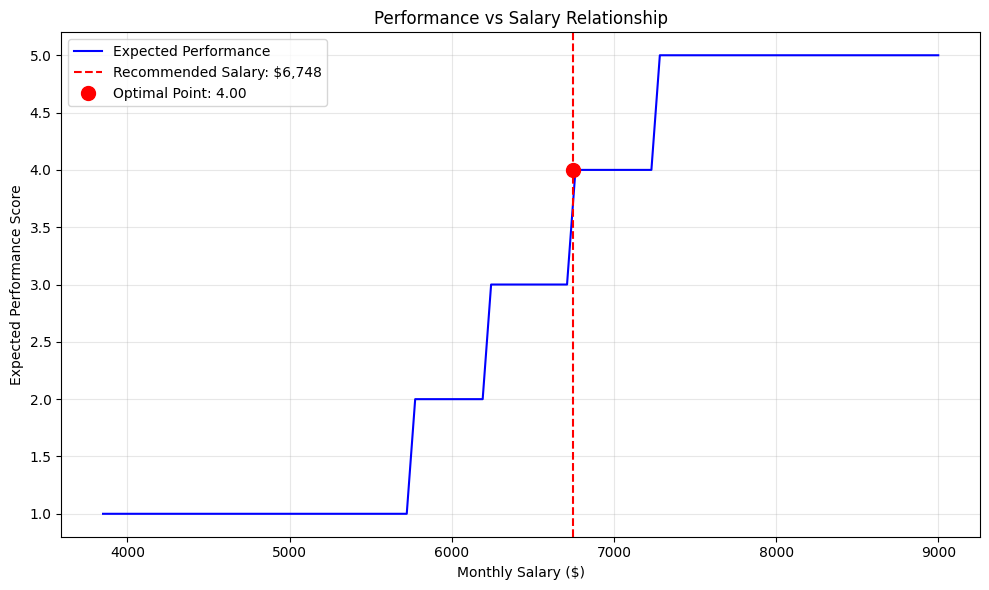

In [22]:
try:
    recommended_salary, expected_performance, cost_per_perf, curve = employer_minimize_salary(
        example_profile, target_performance=4, pay_raise=500
    )
    print(f"✓ Case 4 passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}, Cost/Perf = ${cost_per_perf:.2f}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 4 failed: {e}")

✓ Case 4 passed: Salary = $6740.70, Performance = 4, Cost/Perf = $1685.18


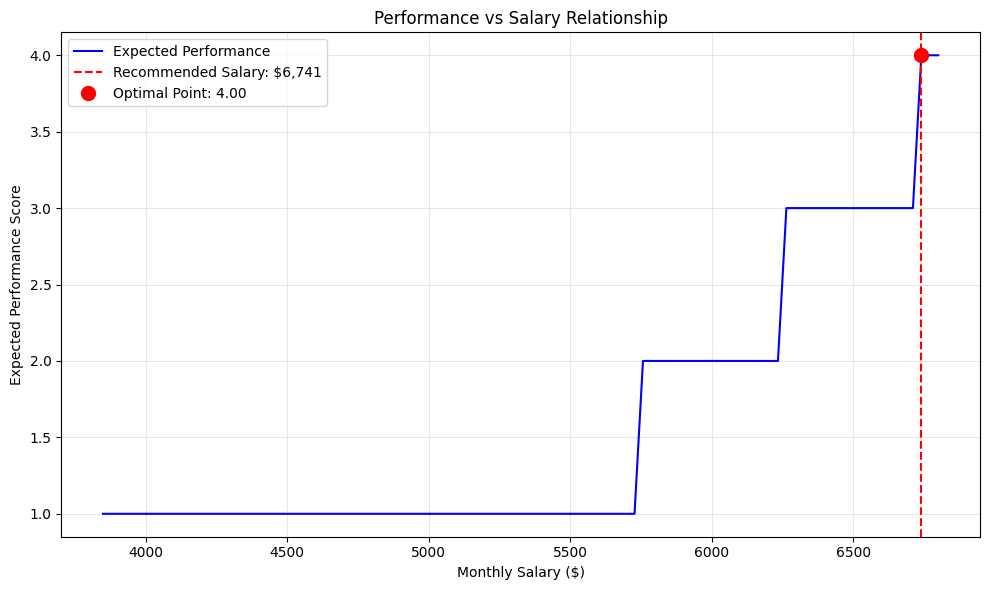

In [23]:
try:
    recommended_salary, expected_performance, cost_per_perf, curve = employer_minimize_salary(
        example_profile, salary_budget=6800, target_performance=4, pay_raise=1000, 
    )
    print(f"✓ Case 4 passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}, Cost/Perf = ${cost_per_perf:.2f}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 4 failed: {e}")

Target performance 4 not achievable within the current budget. Maximum performance at $6600.00 is 3.
✓ Case 4 passed: Salary = $6600.00, Performance = 3, Cost/Perf = $1650.00


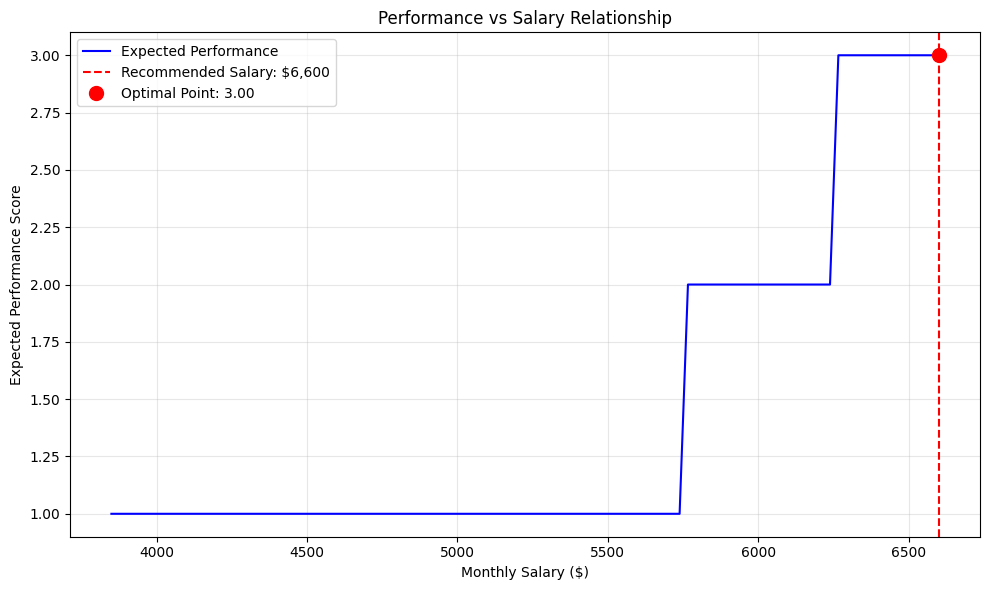

In [24]:
try:
    recommended_salary, expected_performance, cost_per_perf, curve = employer_minimize_salary(
        example_profile, salary_budget=6600, target_performance=4, pay_raise=1000, 
    )
    print(f"✓ Case 4 passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}, Cost/Perf = ${cost_per_perf:.2f}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 4 failed: {e}")

✓ Case 4 passed: Salary = $6240.70, Performance = 3, Cost/Perf = $2228.82


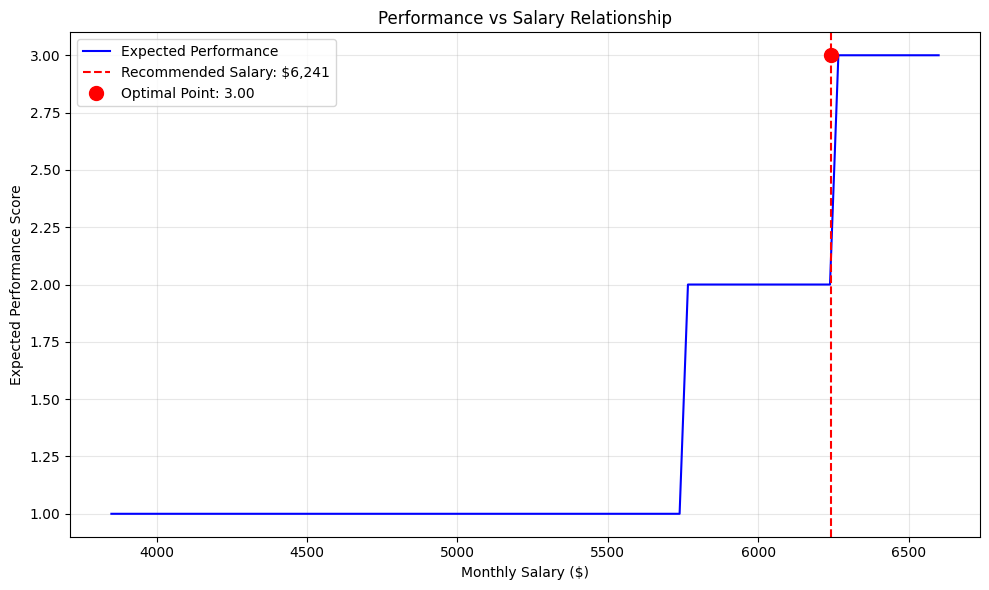

In [25]:
try:
    recommended_salary, expected_performance, cost_per_perf, curve = employer_minimize_salary(
        example_profile, salary_budget=6600, target_performance=2.8, pay_raise=1000, 
    )
    print(f"✓ Case 4 passed: Salary = ${recommended_salary:.2f}, Performance = {expected_performance}, Cost/Perf = ${cost_per_perf:.2f}")
    plot_curve(curve, recommended_salary, expected_performance)
    plt.show()
except Exception as e:
    print(f"✗ Case 4 failed: {e}")

This notebook is done by `La Wun Nannda`.